In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/philippe/MolGenDocking


/home/philippe/miniconda3/envs/MolGen/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

FIG_PATH = "MolGenDocking-latex/Figures/reaction_data"
os.makedirs(FIG_PATH, exist_ok=True)
tqdm.pandas()

# Prompts

In [12]:
from mol_gen_docking.data.pydantic_dataset import read_jsonl
from pathlib import Path

def load(path:str):
    data = read_jsonl(Path(path))
    return [line.conversations[0].meta for line in data]

def get_full_reaction(row: pd.Series):
    full_reac = ""
    for p, reacs in zip(row["products"], row["reactants"]):
        full_reac += " + ".join(reacs) + " -> " + " + ".join(p) + "\n"
    return full_reac[:-1]

def get_n_reactions_steps(row: pd.Series):
    if not row["type of objective"] in ["full synthesis", "product prediction", "full synthesis (with inter.)"]:
        return row["idx_chosen"] + 1
    else:
        return len(row["full_reaction"].split("\n"))

def runtime_get_reactants(row: pd.Series):
    full_reaction = row["full_reaction"]
    reac_steps = full_reaction.split("\n")
    reactants = [
        reac.split(" -> ")[0].split(" + ") for reac in reac_steps
    ]
    return reactants

def runtime_get_products(row: pd.Series):
    full_reaction = row["full_reaction"]
    reac_steps = full_reaction.split("\n")
    products = [
        reac.split(" -> ")[1].split(" + ")[0] for reac in reac_steps
    ]
    return products

def smarts_to_image(smarts):
    rxn = AllChem.ReactionFromSmarts(smarts)
    rxn.Initialize()
    img = AllChem.Draw.ReactionToImage(rxn, subImgSize=(300,300))
    return img

def get_obj_type(obj):
    if "full_path" in obj and "interm" in obj:
        return "full synthesis (with inter.)"
    elif "full_path" in obj:
        return "full synthesis"
    elif "reactant" in obj:
        return "reactant prediction"
    elif "products" in obj:
        return "product prediction"
    elif "product" in obj:
        return "product prediction"
    else:
        return obj

def get_df(data_d):
    df = pd.DataFrame(data_d)
    df= df.explode(["properties", "objectives"]).reset_index(drop=True)
    df["full_reaction"] = df.apply(get_full_reaction, axis=1)
    df["type of objective"]  = df.objectives.apply(get_obj_type)
    df["reaction_steps"] = pd.Categorical(
        df.apply(
           get_n_reactions_steps, axis=1
        ), ordered=True
    )
    return df

df_zinc = pd.read_csv("data/properties.csv")

df_zinc.rename(columns={
    "QED":"qed",
    "CalcExactMolWt":"ExactMolWt",
    "CalcTPSA":"TPSA",
    "CalcNumHBA":"NumHBAcceptors",
    "CalcNumHBD":"NumHBDonors",
    "CalcNumRotatableBonds":"NumRotatableBonds",
    "CalcNumAromaticRings":"NumAromaticRings",
    "CalcHallKierAlpha":"HallKierAlpha",
}, inplace=True)

df = get_df(load("data/synthesis_tasks/train_prompts_json.jsonl"))
df

,objectives,properties,target,reactants,intermediate_products,products,building_blocks,smarts,or_smarts,idx_chosen,full_reaction,type of objective,reaction_steps
0,all_reactants_bb_ref,all_reactants_bb_ref,[CC#CC(=O)Cl],"[[CCOC(=O)c1cc(N)c2ccccc2n1, CCOC1=Cc2n[nH]cc2...",[C#CCN(CCF)C(=O)c1cc(NC2=Cc3n[nH]cc3CC2)c2cccc...,"[CCOC(=O)c1cc(NC2=Cc3n[nH]cc3CC2)c2ccccc2n1, C...","[CC#CC(=O)Cl, COC(=O)c1oc(S(N)(=O)=O)cc1C, CS(...","[[#6:1][C:2](=[O:3])[F,Cl,Br].[NX3;!$(N[C,S]=[...","[[NH2;$(NC),$(Nc),$(NNC(=O)C):1].[C:3]=[C:4]-O...",2,CCOC(=O)c1cc(N)c2ccccc2n1 + CCOC1=Cc2n[nH]cc2C...,reactant prediction,3
1,reactant,reactant,[CCOc1c(Br)cc(C(=O)O)cc1OC],"[[COc1cc(C)c(Br)cc1S(=O)(=O)Cl, ???]]",[],[CCOc1c(OC)cc(C(=O)O)cc1-c1cc(S(=O)(=O)Cl)c(OC...,[],"[[Br,I][C$(C([Br,I])([CX4])([CX4])([CX4])),C$(...","[[Br,I][C$(C([Br,I])([CX4])([CX4])([CX4])),C$(...",0,COc1cc(C)c(Br)cc1S(=O)(=O)Cl + ??? -> C + C + ...,reactant prediction,1
2,full_path_bb_ref,full_path_bb_ref,[CC1=CC(C(=O)N2CC=CC2CF)C=NN1C(=O)Nc1ccccc1C],"[[Cc1ccccc1NC(=O)NN, CCOC(=O)C(C=O)CC(C)=O], [...","[CC1=CC(C(=O)O)C=NN1C(=O)Nc1ccccc1C, CCOC(=O)C...","[CCOC(=O)C1C=NN(C(=O)Nc2ccccc2C)C(C)=C1, CC1=C...","[C=CC(=O)Nc1ccccc1C, CC(=O)CC(=O)Nc1ccccc1C, C...","[[#6:1][NH:2][NH2:3].O=[C;$(C(C)[#6]),$([CH][C...","[[#6:1][NH:2][NH2:3].O=[C;$(C(C)[#6]),$([CH][C...",0,Cc1ccccc1NC(=O)NN + CCOC(=O)C(C=O)CC(C)=O -> C...,full synthesis,3
3,smarts,smarts,"[[NH2;$(NC),$(Nc),$(NNC(=O)C):1].[C:3]=[C:4]-O...","[[CSC#Cc1ccc(C(O)CC(=CCN)c2c(F)cccc2F)nc1, C=C...",[],[C=CNCC=C(CC(O)c1ccc(C#CSC)cn1)c1c(F)cccc1F],[],"[[NH2;$(NC),$(Nc),$(NNC(=O)C):1].[C:3]=[C:4]-O...","[[OH][$([CX4]),c:1]>>[Br][#6:1], [#6:1][C;H1,$...",4,CSC#Cc1ccc(C(O)CC(=CCN)c2c(F)cccc2F)nc1 + C=CO...,smarts,5
4,full_path_bb_ref,full_path_bb_ref,[Nc1nc(-c2ccccc2)c(CC(=O)O)s1],[[O=C(O)CC(Br)C(=O)c1ccccc1]],[],[Nc1nc(-c2ccccc2)c(CC(=O)O)s1],"[CCOC(=O)c1sc(N)nc1-c1ccccc1, CCc1sc(N)nc1-c1c...","[[#6,#1:1][C:2](=O)[C:3]([#6,H:4])[Cl,Br,I]>>[...","[[#6,#1:1][C:2](=O)[C:3]([#6,H:4])[Cl,Br,I]>>[...",0,O=C(O)CC(Br)C(=O)c1ccccc1 -> N + c + 1 + n + c...,full synthesis,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,smarts,smarts,"[[NH2:1][C:2](=S)[N:3]([#6;!$(C=[O,S,N,C]):4])...","[[CC(C)(C)OC(=O)N1CCN(C(N)=S)CC1, Cn1cc(C(=O)N...",[],[Cn1cc(-c2nnc(N3[CH]CN(C(=O)OC(C)(C)C)CC3)[nH]...,[],"[[NH2:1][C:2](=S)[N:3]([#6;!$(C=[O,S,N,C]):4])...","[[NH2:1][C:2](=S)[N:3]([#6;!$(C=[O,S,N,C]):4])...",0,CC(C)(C)OC(=O)N1CCN(C(N)=S)CC1 + Cn1cc(C(=O)NN...,smarts,1
49996,full_path_intermediates_gt_reactants,full_path_intermediates_gt_reactants,[CNC(=O)[C@@H]1Cc2ncccc2C(c2c(O)cc(O)cc2Cl)N1],"[[CNC(=O)[C@@H](N)Cc1ccccn1, O=Cc1c(O)cc(O)cc1...",[CNC(=O)[C@@H]1Cc2ncccc2C(c2c(O)cc(O)cc2O)N1],"[CNC(=O)[C@@H]1Cc2ncccc2C(c2c(O)cc(O)cc2O)N1, ...","[CC(=O)OCCl, CC(C)Oc1cc(Cl)c(C=O)cc1Cl, CN(C)c...","[[NH3+,NH2:1]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)...","[[NH3+,NH2:1]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)...",0,CNC(=O)[C@@H](N)Cc1ccccn1 + O=Cc1c(O)cc(O)cc1O...,full synthesis (with inter.),2
49997,full_path_bb_ref,full_path_bb_ref,[Cc1ccc(C(C)S(=O)(=O)Cc2cccc(N)c2F)cc1],"[[Nc1cccc(CO)c1F], [Nc1cccc(CCl)c1F, Cc1ccc(C(...",[Nc1cccc(CCl)c1F],"[Nc1cccc(CCl)c1F, Cc1ccc(C(C)S(=O)(=O)Cc2cccc(...","[CCc1cccc(N)c1F, Cc1c(N)cccc1CS(C)(=O)=O, NCc1...","[[#6;!$(C=[S,O,N]):1][Cl,$(OS(=O)(=O)[#6;!R])]...","[[OH][$([CX4]),c:1]>>[Cl][#6:1], [#6;!$(C=[S,O...",0,Nc1cccc(CO)c1F -> N + c + 1 + c + c + c + c + ...,full synthesis,2
49998,full_path_intermediates_gt_reactants,full_path_intermediates_gt_reactants,[CNC(=O)NCC(C)(C)Cc1nc2cc(C)ccc2o1],"[[CC(C)(CNC(=O)OC(C)(C)C)CC(=O)O, NCCS(=O)(=O)...","[CC(C)(CNC(=O)OC(C)(C)C)CC(=O)OCCS(=O)(=O)CCN,...","[CC(C)(CNC(=O)OC(C)(C)C)CC(=O)OCCS(=O)(=O)CCN,...","[CC(C)(CNC(=O)OC(C)(C)C)CC(=O)O, CC1C(C)C1(Br)...","[[#6:1][$(CO):2](=O)[O].[NH2:3][c:4][c:5][NH2,...","[[#6:1][C:2](=[O:3])[OH,O-:4].[OH][C;!$(C=[N,O...",0,CC(C)(CNC(=O)OC(C)(C)C)CC(=O)O + NCCS(=O)(=O)C...,full synthesis (with inter.),4


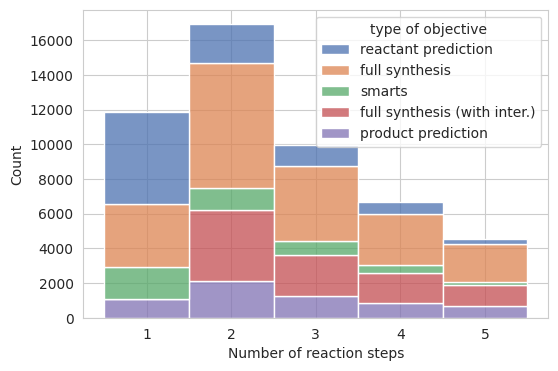

In [13]:
fig,ax = plt.subplots(figsize=(6,4))

sns.histplot(df, x="reaction_steps", hue="type of objective", multiple="stack", palette="deep",ax=ax)
ax.set_xlabel("Number of reaction steps")
ax.set_ylabel("Count")
fig.savefig(os.path.join(FIG_PATH,"reaction_steps_histogram.pdf"), bbox_inches='tight')

In [14]:
df.groupby(["type of objective"]).size() / df.shape[0]


type of objective
full synthesis                  0.40648
full synthesis (with inter.)    0.18864
product prediction              0.11900
reactant prediction             0.19518
smarts                          0.09070
dtype: float64

In [15]:
df.groupby(["type of objective", "objectives"]).size()

type of objective             objectives                          
full synthesis                full_path                               5726
                              full_path_bb_ref                        5842
                              full_path_smarts_bb_ref                 2940
                              full_path_smarts_ref                    5816
full synthesis (with inter.)  full_path_intermediates                 4743
                              full_path_intermediates_gt_reactants    4689
product prediction            final_product                           5950
reactant prediction           all_reactants                           2598
                              all_reactants_bb_ref                    4474
                              reactant                                2687
smarts                        smarts                                  4535
dtype: int64

In [16]:
df.groupby("reaction_steps").size() / df.shape[0]

/tmp/ipykernel_18624/1215546391.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("reaction_steps").size() / df.shape[0]


reaction_steps
1    0.23770
2    0.33814
3    0.19958
4    0.13392
5    0.09066
dtype: float64

In [17]:
from rdkit.Chem import Descriptors
from rdkit import Chem

def get_desc(smi):
    mol = Chem.MolFromSmiles(smi)
    descriptors =  Descriptors.CalcMolDescriptors(mol)
    return descriptors

from multiprocessing import Pool


df_to_descr = df[df.objectives.apply(lambda x: x.startswith("f"))]
with Pool(8) as p:
    descs = list(tqdm(p.imap(get_desc, [x[-1] for x in df_to_descr["products"]]), total=len(df_to_descr)))

df_descriptors = pd.DataFrame(descs)
df_descriptors = df_descriptors.rename(columns={"NumHAcceptors":"NumHBAcceptors", "NumHDonors":"NumHBDonors"})

100%|██████████| 35706/35706 [00:57<00:00, 625.40it/s]


In [18]:
from mol_gen_docking.data.reactions.utils import PROP_TARGET_DISTRIB_FN

def plot_descriptor_distributions(df_descriptors, df_zinc):
    fig, axes = plt.subplots(2,4, figsize=(12,5))
    axes = axes.flatten()
    for i,col in enumerate(
        [
            "qed",
            "ExactMolWt",
            "TPSA",
            "NumHBAcceptors",
            "NumHBDonors",
            "NumRotatableBonds",
            "NumAromaticRings",
            "HallKierAlpha",
        ]
    ):
        sns.histplot(df_zinc, x=col, ax=axes[i], color="black",label="ZINC", alpha=0.7, stat="density", bins=10)
        sns.histplot(
            df_descriptors, x=col, hue=df["reaction_steps"], ax=axes[i],
            palette="viridis", stat="density", multiple="stack",
            legend=i == len(axes)-1, bins= 10
        )
        axes[i].set_title(col)
    fig.tight_layout()

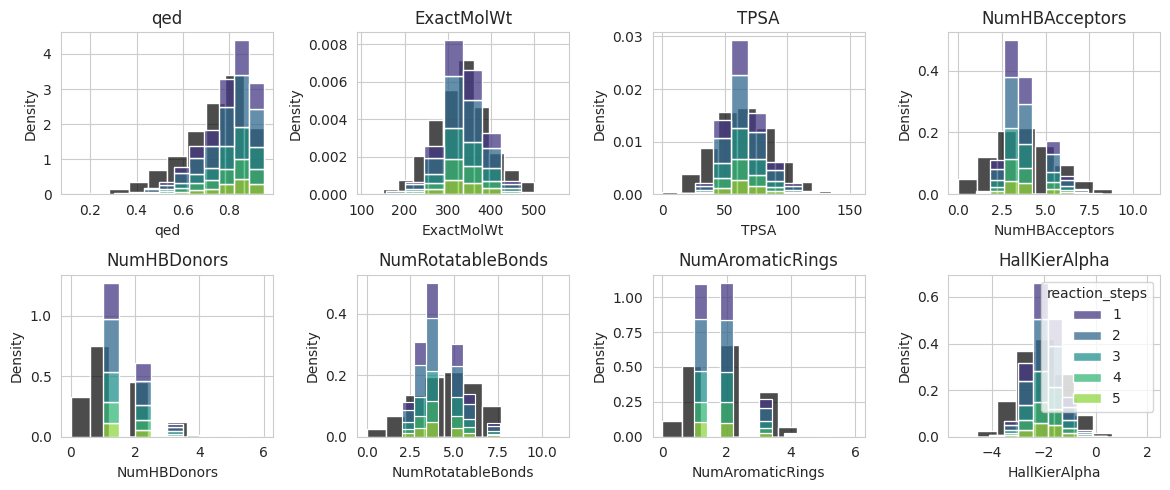

In [19]:
plot_descriptor_distributions(df_descriptors, df_zinc)

In [20]:
df_per_step = df[df.objectives.apply(lambda x: x.startswith("f"))][["products", "reactants", "or_smarts",]]

df_per_step = df_per_step.sample(frac=0.5)
df_per_step["n_step"] =df_per_step.products.apply(lambda x: list(range(1,1+len(x))))
df_per_step["id"] = df_per_step.index
df_per_step["n_tot_step"] = df_per_step.products.apply(len)
df_per_step["last_product"] = df_per_step.n_tot_step.apply(lambda x: [False] * (x-1) + [True])
df_per_step = df_per_step.explode(["reactants","products", "or_smarts", "n_step", "last_product"])
df_per_step["n_reactants"] = pd.Categorical(df_per_step.reactants.apply(len), ordered=True)

df_per_step["prop_step"] = df_per_step["n_step"] / df_per_step["n_tot_step"]

print("Total number of steps exploded: ", df_per_step.shape[0])

Total number of steps exploded:  49153


In [21]:
with Pool(8) as p:
    descs = list(tqdm(p.imap(get_desc, df_per_step["products"]), total=len(df_per_step)))

df_descriptors_step = pd.DataFrame(descs)


df_descriptors_step = pd.concat([
    df_per_step.reset_index(drop=True),
    df_descriptors_step.rename(columns={"NumHAcceptors":"NumHBAcceptors", "NumHDonors":"NumHBDonors"})
], axis=1)

100%|██████████| 49153/49153 [03:03<00:00, 268.53it/s]


In [22]:
df_zinc

,Unnamed: 0,smiles,GSK3B,JNK3,DRD2,SA,qed,ExactMolWt,NumAromaticRings,NumHBAcceptors,...,logP,3pbl_docking,1iep_docking,2rgp_docking,3eml_docking,3ny8_docking,4rlu_docking,4unn_docking,5mo4_docking,7l11_docking
0,0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,0.03,0.01,0.000492,2.084095,0.731901,325.147807,3.0,2.0,...,3.139906,-8.4,-8.3,-9.2,-9.1,-9.6,-9.5,-8.1,-9.3,-6.4
1,1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,0.16,0.01,0.016065,3.432004,0.941112,285.195346,2.0,5.0,...,0.172386,-8.1,-7.8,-8.0,-8.3,-8.2,-8.7,-7.8,-7.3,-6.4
2,2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,0.03,0.03,0.012857,2.470633,0.626105,382.168128,3.0,3.0,...,2.618423,-9.4,-7.9,-8.1,-9.4,-9.3,-10.4,-8.4,-9.2,-6.9
3,3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,0.00,0.00,0.002011,2.822753,0.716225,409.236542,2.0,5.0,...,-1.974847,-7.4,-5.6,-8.4,-7.9,-5.0,-9.6,-8.1,-8.0,-6.7
4,4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,0.00,0.02,0.000841,4.035182,0.809572,413.084448,1.0,6.0,...,-0.205555,-9.1,-9.1,-8.5,-9.0,-9.2,-5.6,-7.5,-7.7,-7.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249403,249403,CCn1ccnc1SCCN1C(=O)NC2(CCCC2)C1=O,0.03,0.01,0.001544,3.079811,0.665806,308.130697,1.0,5.0,...,-0.279357,-7.3,-6.6,-7.8,-7.0,-7.5,-7.3,-6.3,-7.0,-6.1
249404,249404,Cc1nc(NC(=O)c2cccc(SC(C)C)c2)sc1C,0.01,0.01,0.000242,2.160662,0.844870,306.086055,2.0,4.0,...,2.673054,-7.8,-7.4,-7.7,-7.6,-7.7,-7.4,-6.9,-7.3,-6.1
249405,249405,O=C(CCc1c[nH]c2ccccc12)Nc1ccc(N2CCc3sccc3C2)nc1,0.09,0.02,0.006480,2.383562,0.505998,402.151432,4.0,4.0,...,2.576906,-10.3,-10.2,-10.7,-10.4,-9.9,-10.7,-7.8,-8.4,-7.1
249406,249406,CCCCCNC(=O)N(C)CCS(C)(=O)=O,0.00,0.00,0.000256,2.235710,0.681559,250.135114,0.0,3.0,...,0.038167,-5.4,-5.9,-6.2,-5.5,-5.9,-6.2,-5.7,-5.9,-5.0


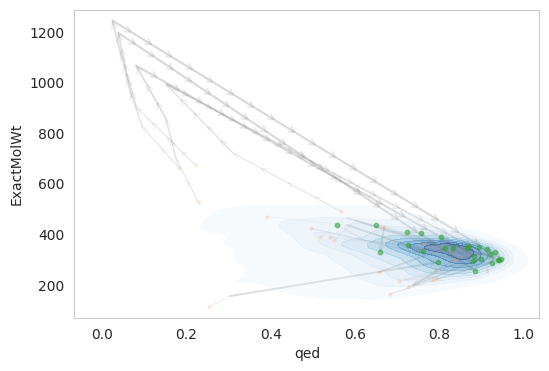

In [23]:
N_TO_PLOT = 25

col_a = "ExactMolWt"
col_b = "qed"

colors = sns.color_palette("rocket_r", as_cmap=True, )

df_toplot = df_descriptors_step[df_descriptors_step.id.isin(df_descriptors_step.sample(2*N_TO_PLOT, replace=True).id.unique()[:N_TO_PLOT])]

df_kde = pd.concat([
    df_zinc[[col_b, col_a]].sample(10000),
    df_toplot[[col_b, col_a]]
], axis=0)

fig, ax = plt.subplots(figsize=(6, 4))

sns.kdeplot(
    data=df_kde, x=col_b, y=col_a,
    fill=True, ax=ax, alpha=0.5, levels=10,
    thresh=0.01, cmap="Blues"
)

l_step = ((df_toplot[col_a].max() - df_toplot[col_a].min()) **2 + (df_toplot[col_b].max() - df_toplot[col_b].min())**2)**0.5 /25
for mol_id in df_toplot.id.unique():
    sub_df = df_toplot[df_toplot.id == mol_id].sort_values("n_step")
    for i in range(len(sub_df)-1):
        x0,y0 = sub_df[col_b].iloc[i], sub_df[col_a].iloc[i]
        x1, y1 = sub_df[col_b].iloc[i+1], sub_df[col_a].iloc[i+1]
        ax.plot(
            [x0,x1], [y0,y1], color="gray",
            alpha=0.1 * sub_df.prop_step.iloc[i]**2 + 0.1,
            lw=1.5 * sub_df.prop_step.iloc[i]**0.5 + 0.1,
            zorder=0
        )
        n_arrows = int(((x1-x0)**2 + (y1-y0)**2)**0.5 / l_step)
        xs = np.linspace(x0, x1, n_arrows)
        ys = np.linspace(y0, y1, n_arrows)
        for i_s in range(len(xs)-1):
            ax.annotate(
                '', xy=(xs[i_s+1], ys[i_s+1]),
                xytext=(xs[i_s], ys[i_s]),
                arrowprops=dict(
                    arrowstyle='->',
                    color='gray',
                    alpha=0.1 * sub_df.prop_step.iloc[i]**2 + 0.1,
                    lw=1.5 * sub_df.prop_step.iloc[i]**0.5 + 0.1,
                    shrinkA=0.0,
                    shrinkB=0.0,
                )
            )
sub_df = df_toplot[df_toplot.n_step == 1]
ax.scatter(
    sub_df[col_b], sub_df[col_a], s=5, zorder=1, alpha = 0.1
)
sub_df = df_toplot[df_toplot.last_product]
ax.scatter(
    sub_df[col_b], sub_df[col_a], s=10, zorder=10, alpha = 0.5,
)

ax.grid(False)
plt.show()

/tmp/ipykernel_18624/463335299.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupby = df_per_step.groupby(["n_reactants"]).size()


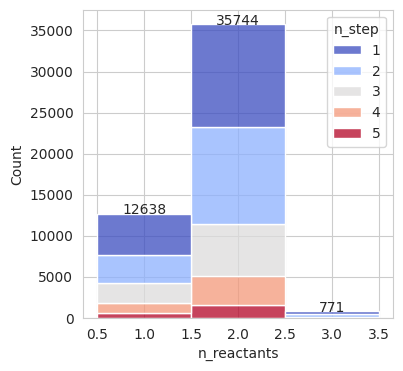

In [24]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

sns.histplot(df_per_step, x="n_reactants", hue="n_step", multiple="stack", palette="coolwarm")
groupby = df_per_step.groupby(["n_reactants"]).size()

for k in df_per_step.n_reactants.unique():
    ax.annotate(
        f"{groupby.loc[k]}",
        xy=(k, groupby.loc[k]),          # target (bar)
        xycoords='data',
        ha='center'
    )

In [25]:
map_smarts_to_id = {smarts: idx for idx, smarts in enumerate(df_per_step.groupby("or_smarts").size().sort_values(ascending=False).index.tolist())}
df_per_step["smarts_id"] = pd.Categorical(df_per_step["or_smarts"].map(map_smarts_to_id), ordered=True)

In [26]:
def smarts_to_image(smarts):
    rxn = AllChem.ReactionFromSmarts(smarts)
    img = AllChem.Draw.ReactionToImage(rxn, subImgSize=(300,300))
    return img

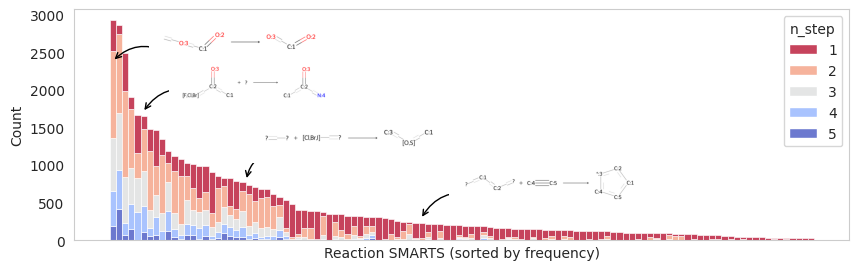

In [27]:
from rdkit.Chem import AllChem

fig, ax = plt.subplots(figsize=(10,3))

sns.histplot(df_per_step, x="smarts_id", hue="n_step", multiple="stack",
             palette="coolwarm_r", ax=ax)

ax.grid(False)
ax.set_xlabel("Reaction SMARTS (sorted by frequency)")
ax.set_ylabel("Count")
ax.set_xticks([])  # Hide x-axis ticks for clarity

plot_inf = [ # (x, y, zoom)
    (0.19, 0.67, 0.2),
    (0.22, 0.55, 0.17),
    (0.3, 0.35, 0.2),
    (0.5, 0.2, 0.2)
]

for smarts_id, (image_xaxis, image_yaxis, zoom) in zip([0, 5, 22, 50], plot_inf):
    smarts = list(map_smarts_to_id.keys())[smarts_id]
    img = smarts_to_image(smarts)

    # Create inset axes for the SMARTS image
    ax_image = fig.add_axes([image_xaxis, image_yaxis, zoom, zoom])
    ax_image.imshow(img)
    ax_image.axis('off')

    # Compute approximate histogram height for arrow target
    count = df_per_step[df_per_step.smarts_id == smarts_id].shape[0]
    arr_mult = 1 if smarts_id != 0 else 0.8

    # Add a *curved* arrow connecting the image and the histogram bar
    ax.annotate(
        '',
        xy=(smarts_id-0.5, arr_mult * count),          # target (bar)
        xycoords='data',
        xytext=(image_xaxis- zoom*0.1, image_yaxis + zoom/4),  # start (center of image)
        textcoords='figure fraction',
        arrowprops=dict(
            arrowstyle="->",
            color='black',
            lw=1.,
            shrinkA=5,
            shrinkB=5,
            connectionstyle="arc3,rad=0.4"  # <--- makes it curved
        )
    )

fig.savefig(os.path.join(FIG_PATH, "smarts_histogram_with_images.pdf"), bbox_inches='tight')


In [28]:
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold


df_simi = {
    "n_steps": [],
    "similarity": [],
    "quantile": []
}

QUANTILES = [10**-i for i in np.linspace(1., 4, 100)]

def agg_tanimoto_sim(sub_df):
    """ Get the average tanimoto similarity between all products in the sub_df"""
    mols = [Chem.MolFromSmiles(smi) for smi in sub_df.products]
    for smi, mol in zip(sub_df.products, mols):
        if mol is None:
            print(f"Invalid SMILES: {smi}")
    fps = [
        AllChem.GetMorganFingerprintAsBitVect(m, 2, 2048)
        for m in mols
    ]
    n = len(fps)
    if n <=1:
        return 1.0
    sims = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1, n):
            sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
            sims[i,j] = sim
            sims[j,i] = sim
    return [np.quantile(sims, 1-q, axis=1) for q in QUANTILES]

for n_steps in tqdm(df_per_step.n_step.unique()):
    sims = agg_tanimoto_sim(df_per_step[df_per_step.n_step==n_steps].sample(1000))
    for i_q, q in enumerate(QUANTILES):
        quantile_sim = sims[i_q]
        for i in range(len(quantile_sim)):
            df_simi["n_steps"].append(n_steps)
            df_simi["similarity"].append(quantile_sim[i])
            df_simi["quantile"].append(q)

df_simi = pd.DataFrame(df_simi)

100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


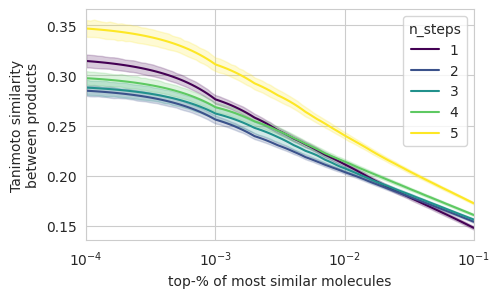

In [29]:
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(df_simi, x="quantile", y="similarity", hue="n_steps", palette="viridis",ax=ax)
ax.set_xlim(10**-4,0.1)
ax.set_xscale("log")
ax.set_xlabel("top-% of most similar molecules")
ax.set_ylabel("Tanimoto similarity\nbetween products")

fig.savefig(os.path.join(FIG_PATH,"tanimoto_similarity_per_reaction_step.pdf"), bbox_inches='tight')

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdMolDraw2D
import io
from PIL import Image, ImageDraw, ImageFont

def plot_mol_high(mol, size, high, bond_high, rgba, width):
    drawer = rdMolDraw2D.MolDraw2DCairo(*size)
    drawer.drawOptions().fillHighlights=True
    drawer.drawOptions().setHighlightColour((rgba))
    drawer.drawOptions().highlightBondWidthMultiplier=width
    drawer.drawOptions().clearBackground = False
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, highlightAtoms=high,  highlightBonds=bond_high)
    bio = io.BytesIO(drawer.GetDrawingText())
    return Image.open(bio)

def reactions_to_image(smarts, reactants, size=(300, 300), rgba_color= (0.0,0.0,1.0,0.1), rgba_color_prod= (1.0,0.0,0.0,0.1), highlight_width=20):
    # Convert reactants to RDKit molecule objects
    reactant_mols = []
    for r in reactants:
        mol = Chem.MolFromSmiles(r, sanitize=True) if isinstance(r, str) else r
        reactant_mols.append(mol)

    # Create a reaction object from the SMARTS pattern
    rxn = AllChem.ReactionFromSmarts(smarts)
    rxn.Initialize()
    print(rxn.GetNumReactantTemplates())
    # Predict the products using the actual reactants
    products = rxn.RunReactants(reactant_mols)
    # Create a new reaction object with the actual reactants and predicted products

    reactant_highlights = []
    reactant_bond_highlights = []
    for mol, substructure in zip(reactant_mols, rxn.GetReactants()):
        # mol.GetImplicitValence()
        match = mol.GetSubstructMatches(substructure)
        reactant_bond_highlights.append([])
        for bond in mol.GetBonds():
            aid1 = bond.GetBeginAtomIdx()
            aid2 = bond.GetEndAtomIdx()
            if aid1 in match[0] and aid2 in match[0]:
                reactant_bond_highlights[-1].append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())
        reactant_highlights.append(match)
    products_highlights = []

    product = products[0][0]
    substructure = rxn.GetProducts()[0]

    match = product.GetSubstructMatches(substructure)
    products_highlights.append(match[0])
    product_bond_highlights =[]
    for bond in product.GetBonds():
        aid1 = bond.GetBeginAtomIdx()
        aid2 = bond.GetEndAtomIdx()
        if aid1 in match[0] and aid2 in match[0]:
            product_bond_highlights.append(product.GetBondBetweenAtoms(aid1,aid2).GetIdx())

    reactants_image = []
    for mol, high, bonds in zip(reactant_mols, reactant_highlights, reactant_bond_highlights):
        reactants_image.append(plot_mol_high(mol, size, high[0], bonds, rgba_color, highlight_width))

    prod_img = plot_mol_high(products[0][0], size, products_highlights[0], product_bond_highlights, rgba_color_prod, highlight_width)

    return reactants_image, prod_img

def pil_to_array(img, pad = 0.2):
    if not isinstance(img, Image.Image):
        arr= np.asarray(Image.open(io.BytesIO(img.data)))
    else:
        if img.mode != 'RGB':
            img.load()
            new_img = Image.new("RGB", img.size, (255,255,255))
            new_img.paste(img, mask=img.split()[3])
            arr =  np.asarray(new_img)
        else:
            arr = np.asarray(img)
    idx_non_w = np.where(~(arr.sum(-1) == 255 *3).all(0))[0]
    x_min, x_max = min(idx_non_w), max(idx_non_w)
    arr = arr[:,x_min:x_max,:]
    # Pad
    pad_size = int((x_max - x_min) * pad)
    arr = np.concatenate([255*np.ones_like(arr)[:,:pad_size], arr, 255 *np.ones_like(arr)[:,:pad_size]], axis=1)

    return arr

def text_image(text, height):
    """Create a small image with a centered text like '+' or '→'."""
    W, H = int(height * 0.3), height
    img = Image.new("RGB", (W, H), "white")
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("arial.ttf", int(height*10))
    except:
        font = ImageFont.load_default()

    # Use textbbox to get the bounding box of the text
    bbox = draw.textbbox((0, 0), text, font=font)
    w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]

    draw.text(((W - w)//2, (H - h)//2), text, fill="black", font=font)
    return img


def pad_image_to_height(img_array, target_height):
    """
    Pad a NumPy image array vertically to match target_height.
    Assumes img_array is a 2D or 3D NumPy array (e.g., grayscale or RGB).
    """
    current_height, current_width = img_array.shape[:2]
    if current_height >= target_height:
        return img_array  # No padding needed
    # Calculate padding
    pad_top = (target_height - current_height) // 2
    pad_bottom = target_height - current_height - pad_top
    # Pad the image
    padded_img = np.pad(
        img_array,
        ((pad_top, pad_bottom), (0, 0), (0, 0)),
        mode='constant',
        constant_values=255  # White padding
    )

    return padded_img


def draw_reaction_on_ax(ax, reactant_imgs, product_img, pad_size = 0.2, height = 300, link_zooms = [0.5,0.1]):
    """
    reactant_imgs: list of PIL images
    product_img: PIL image
    """

    # Convert images to arrays
    link_img = [Image.open("notebooks/plus.png"), Image.open("notebooks/arrow.png")]
    link_img_array = []
    for zoom, img in zip(link_zooms,link_img):
        ratio = height / img.height * zoom
        new_width = int(img.width * ratio)
        new_height = int(img.height * ratio)
        img_resized = img.resize((new_width, new_height), Image.LANCZOS)
        img_array = pad_image_to_height(pil_to_array(img_resized), height)
        link_img_array.append(img_array)

    arrays = []
    for i,img in enumerate(reactant_imgs):
        arrays.append(pil_to_array(img, pad_size))
        arrays.append(link_img_array[int(i == len(reactant_imgs) - 1)])
    arrays.append(pil_to_array(product_img,pad_size))

    full = np.concatenate(arrays, axis=1)

    # Display
    ax.imshow(full)
    ax.axis("off")



In [ ]:
errs = []

In [ ]:
n_rxns = len(map_smarts_to_id) - len(errs)
reactants = df_per_step[~df_per_step.impossible].groupby("or_smarts")["reactants"].apply(lambda x: np.random.choice(x))

n_cols = 5
fig, axes = plt.subplots(n_rxns // n_cols+1, n_cols, figsize=(8*n_cols,4*n_rxns // n_cols))
axes = axes.flatten()
i_curr = 0
for i,rxn in enumerate(map_smarts_to_id):
    if i in errs:
        continue
    failed = 0
    for _ in range(30):
        try:
            reactant_imgs, product_img = reactions_to_image(
                rxn,
                [Chem.MolFromSmiles(r) for r in reactants.loc[rxn]],
                size=(500, 500),
                highlight_width=10,
                rgba_color=(1.0,0.0,1.0,0.7),
                rgba_color_prod=(1.0,0.5,0.5,0.7),
            )
            draw_reaction_on_ax(axes[i_curr], reactant_imgs, product_img, pad_size=0.1, height=500)
            i_curr += 1
            break
        except Exception as e:
            print(e)
            reactants = df_per_step[~df_per_step.impossible].groupby("or_smarts")["reactants"].apply(lambda x: np.random.choice(x))
            failed += 1

        if failed == 10:
            errs.append(i)

for i in range(i_curr, len(axes)):
    axes[i].axis("off")

fig.tight_layout()
fig.savefig(f"{FIG_PATH}/reaction_dataset.pdf", bbox_inches="tight")

In [ ]:
row_retro = df[(df.reaction_steps == 4) & (df["type of objective"] == "full synthesis")].sample(1)

full_synth = row_retro.full_reaction.iloc[0]

reactants = row_retro.all_reactants.iloc[0]
smarts = row_retro.or_smarts.iloc[0]
row_retro

In [ ]:
reactants

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(10,40))
axes = axes.flatten()


i_curr = 0
for rxn, reac in zip(smarts, reactants):
    reactant_imgs, product_img = reactions_to_image(
        rxn,
        [Chem.MolFromSmiles(r) for r in reac],
        size=(500, 500),
        highlight_width=10,
        rgba_color=(1.0,0.0,1.0,0.7),
        rgba_color_prod=(1.0,0.5,0.5,0.7),
    )
    draw_reaction_on_ax(axes[i_curr], reactant_imgs, product_img, pad_size=0.1, height=500)
    i_curr += 1


fig.savefig(f"{FIG_PATH}/retro_synth_ex.pdf", bbox_inches="tight")

In [ ]:
reactants